In [1]:
import duckdb
import pandas as pd
import requests
import json
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pickle
import joblib

from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression

In [14]:
path = "../data/diamonds_train.db"
conn = duckdb.connect(path, read_only=True)
df = conn.execute('show tables').fetch_df()
df

,name
0,diamonds_city
1,diamonds_clarity
2,diamonds_color
3,diamonds_cut
4,diamonds_dimensions
5,diamonds_properties
6,diamonds_transactional
7,sqlite_autoindex_diamonds_city_1
8,sqlite_autoindex_diamonds_clarity_1
9,sqlite_autoindex_diamonds_color_1


In [15]:
df1 = []

In [16]:
for i, row in df.iterrows():
    df1.append(conn.execute('SELECT * FROM ' + row[0]).fetch_df())
    if (i > 5):
        break
    print('\n')

In [17]:

my_df = conn.execute('SELECT dt.price ,dt.carat, dc.city,  dd."depth", dd."table" ,dd.x , dd.y , dd.z, dc2.clarity , dc3.color , dc4.cut  FROM diamonds_transactional dt INNER JOIN diamonds_properties dp ON dt.index_id = dp.index_id INNER JOIN diamonds_dimensions dd  ON dd.index_id = dt.index_id INNER JOIN diamonds_city dc ON dc.city_id = dt.city_id INNER JOIN diamonds_clarity dc2 ON dc2.clarity_id = dp.clarity_id INNER JOIN diamonds_color dc3 ON dc3.color_id = dp.color_id INNER JOIN diamonds_cut dc4 ON dc4.cut_id = dp.cut_id ').fetch_df()

In [18]:
my_df

,price,carat,city,depth,table,x,y,z,clarity,color,cut
0,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,VS2,H,Very Good
1,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,VS1,G,Fair
2,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,SI1,D,Good
3,9057,1.52,Tel Aviv,61.2,57.0,7.45,7.39,4.54,SI2,F,Ideal
4,557,0.31,Zurich,61.8,54.2,4.33,4.37,2.69,VS1,H,Ideal
...,...,...,...,...,...,...,...,...,...,...,...
40450,1116,0.35,Amsterdam,62.2,58.0,4.52,4.45,2.79,IF,G,Premium
40451,975,0.40,Luxembourg,62.4,55.0,4.74,4.71,2.95,VS2,E,Ideal
40452,8572,1.57,Tel Aviv,61.1,61.0,7.46,7.43,4.55,SI2,G,Premium
40453,5154,0.73,Paris,61.4,56.0,5.80,5.81,3.56,VVS1,F,Ideal


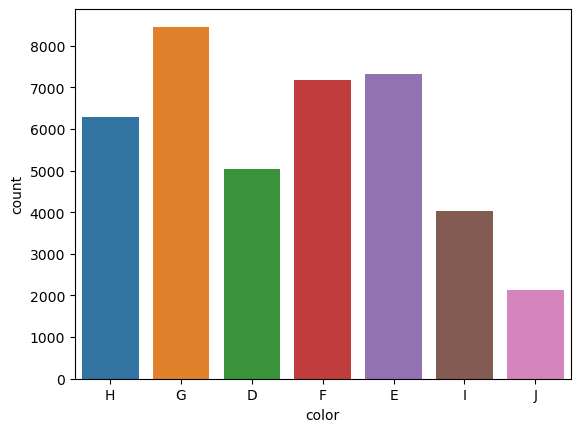

In [19]:
ax = sns.countplot(x="color", data=my_df)

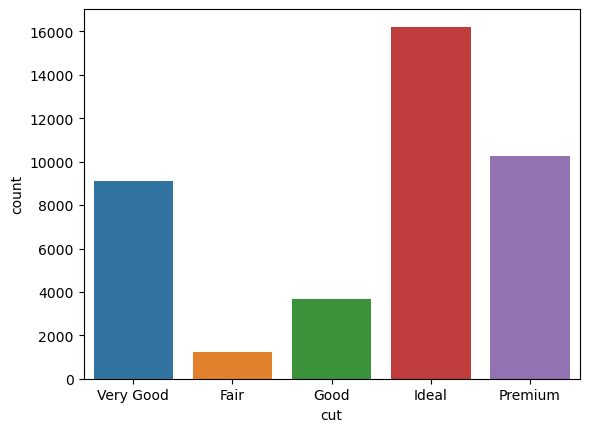

In [20]:
ax = sns.countplot(x="cut", data=my_df)

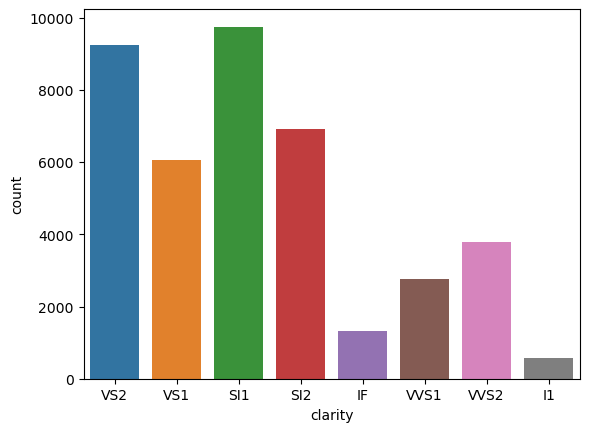

In [21]:
ax = sns.countplot(x="clarity", data=my_df)

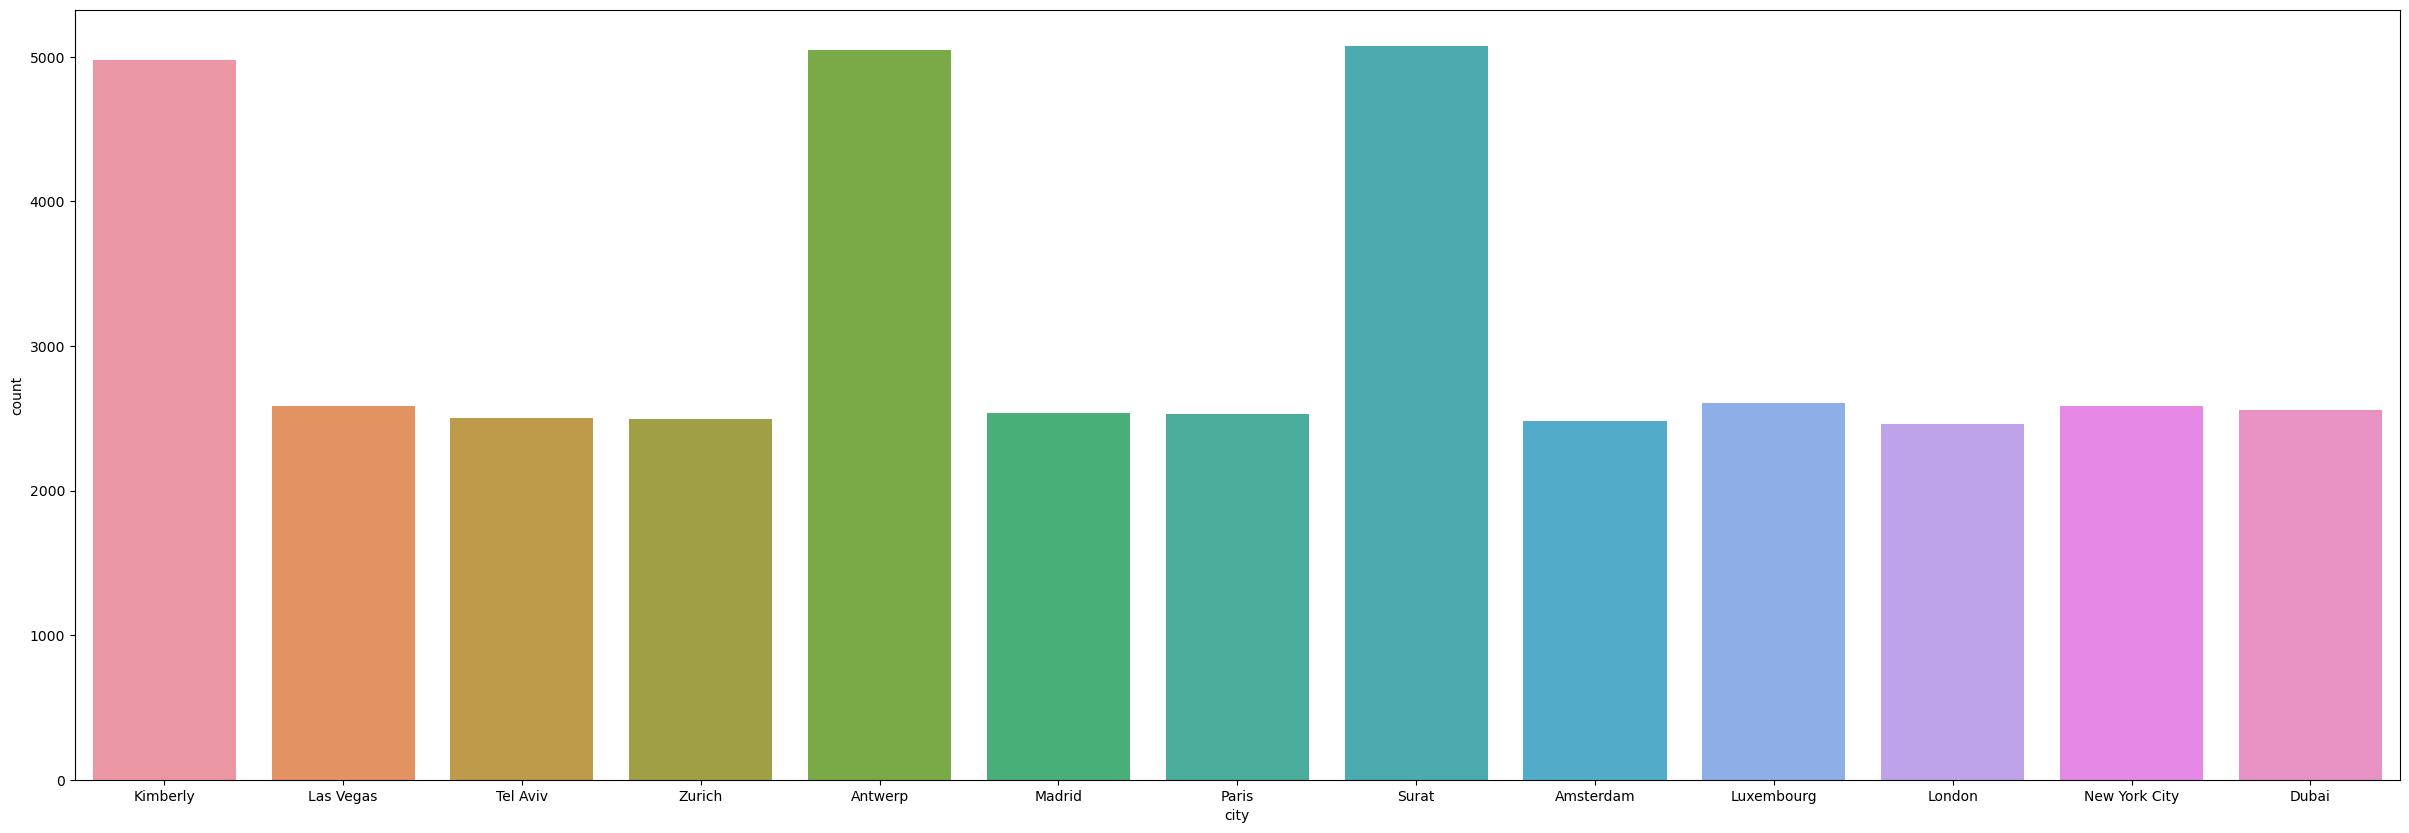

In [22]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.countplot(x="city", data=my_df)

<Axes: xlabel='color', ylabel='price'>

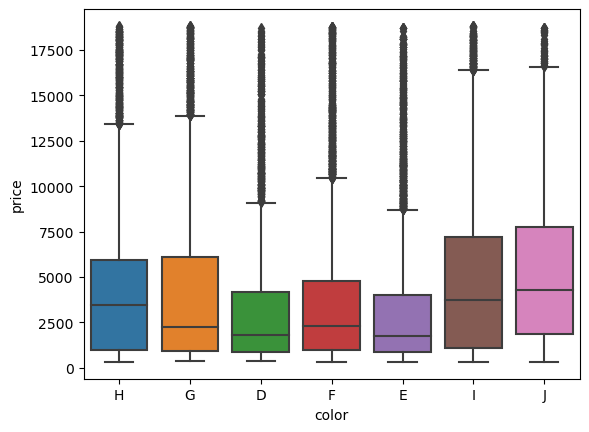

In [23]:
sns.boxplot(data=my_df, x="color", y="price")

<Axes: xlabel='color', ylabel='price'>

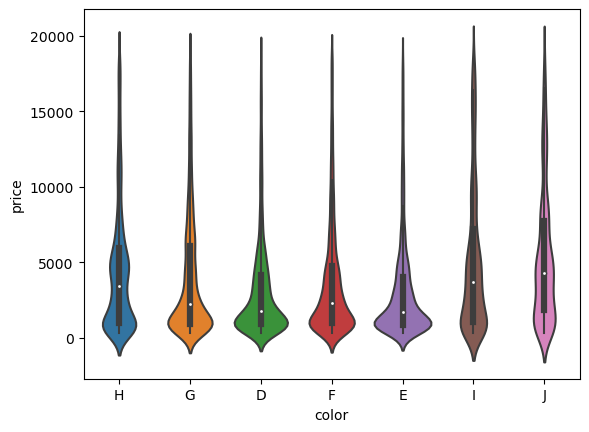

In [24]:
sns.violinplot(data=my_df, x="color", y="price")

<Axes: xlabel='clarity', ylabel='price'>

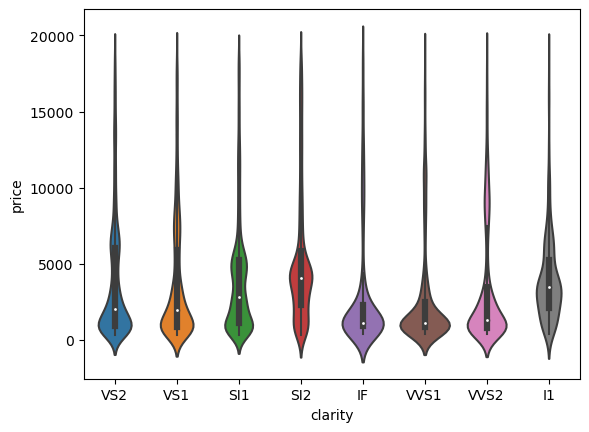

In [25]:
sns.violinplot(data=my_df, x="clarity", y="price")

<Axes: xlabel='cut', ylabel='price'>

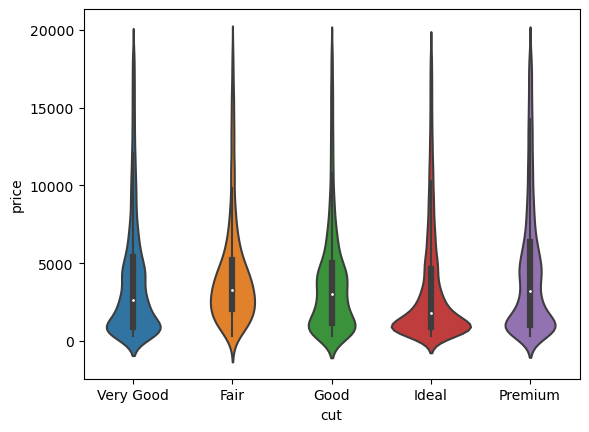

In [26]:
sns.violinplot(data=my_df, x="cut", y="price")

<Axes: >

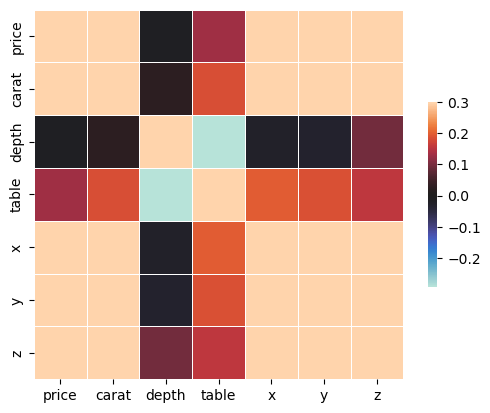

In [27]:
sns.heatmap(my_df.corr(numeric_only=True), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [28]:
df_base = my_df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']]
df_base

,carat,depth,table,x,y,z,price
0,0.32,63.0,57.0,4.35,4.38,2.75,505
1,0.71,65.5,55.0,5.62,5.53,3.65,2686
2,0.41,63.8,56.0,4.68,4.72,3.00,738
3,1.52,61.2,57.0,7.45,7.39,4.54,9057
4,0.31,61.8,54.2,4.33,4.37,2.69,557
...,...,...,...,...,...,...,...
40450,0.35,62.2,58.0,4.52,4.45,2.79,1116
40451,0.40,62.4,55.0,4.74,4.71,2.95,975
40452,1.57,61.1,61.0,7.46,7.43,4.55,8572
40453,0.73,61.4,56.0,5.80,5.81,3.56,5154


In [29]:
df_base.to_csv("./../data/df_baseline.csv", index=False)

In [51]:
X = df_base[['carat', 'depth', 'table', 'x', 'y', 'z']].values
X

array([[ 0.32, 63.  , 57.  ,  4.35,  4.38,  2.75],
       [ 0.71, 65.5 , 55.  ,  5.62,  5.53,  3.65],
       [ 0.41, 63.8 , 56.  ,  4.68,  4.72,  3.  ],
       ...,
       [ 1.57, 61.1 , 61.  ,  7.46,  7.43,  4.55],
       [ 0.73, 61.4 , 56.  ,  5.8 ,  5.81,  3.56],
       [ 0.39, 61.7 , 57.  ,  4.68,  4.71,  2.89]])

In [62]:
y = df_base['price'].values
y

array([ 505, 2686,  738, ..., 8572, 5154, 1148])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (32364, 6), X_test: (8091, 6), y_train: (32364,), y_test: (8091,)


In [64]:
X_test

array([[ 0.3 , 63.7 , 59.  ,  4.17,  4.24,  2.68],
       [ 1.21, 62.3 , 59.  ,  6.81,  6.77,  4.23],
       [ 0.3 , 61.8 , 55.  ,  4.32,  4.35,  2.68],
       ...,
       [ 1.22, 61.9 , 60.  ,  6.88,  6.82,  4.24],
       [ 0.85, 60.7 , 55.  ,  6.14,  6.19,  3.74],
       [ 0.38, 63.3 , 57.  ,  4.62,  4.58,  2.91]])

In [73]:
#model = LinearRegression()
model = SVR()

In [74]:
model.fit(X_train, y_train)

SVR()

In [75]:
predictions = model.predict(X_test)

print(len(predictions))

8091


In [77]:
# Visual check

check = pd.DataFrame({'Ground truth':y_test, 'Predictions':predictions, 'Diff':y_test-predictions})
check

,Ground truth,Predictions,Diff
0,752,2357.975915,-1605.975915
1,5556,2451.287482,3104.712518
2,606,2339.111023,-1733.111023
3,3123,2411.485377,711.514623
4,1563,2413.382228,-850.382228
...,...,...,...
8086,6399,2440.181074,3958.818926
8087,1104,2382.699637,-1278.699637
8088,6969,2458.392418,4510.607582
8089,3441,2404.209523,1036.790477


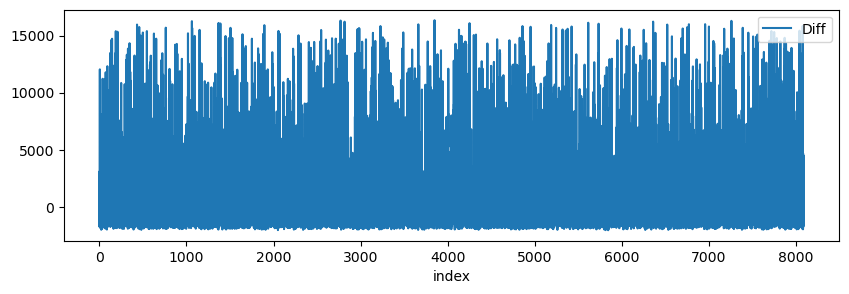

In [78]:

check.reset_index(inplace=True)

check.plot(x='index', y=['Diff'], kind='line', figsize=(10, 3));

In [ ]:
test_df = pd.read_csv("./data/diamonds_test.csv")
test_df

In [ ]:
predictions = model.predict(test_df[['carat', 'depth', 'table', 'x', 'y', 'z']])


In [ ]:
df_sub = pd.DataFrame(predictions).reset_index()
df_sub.columns = ['id', 'price']

In [ ]:
df_sub

In [ ]:
#df_sub.to_csv("./submissions/first_try_linear.csv", index=False)
#df_sub.to_csv("./submissions/first_SVR.csv", index=False)